## Exploratory Data Analysis

- Antibody usage by checkpoint
- Interface length and residue frequency

In [1]:
# Import statements
import numpy as numpy
import pandas as pd
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
import random
import os
from scipy.stats import zscore
from collections import Counter
import requests
from Bio.PDB import PDBParser, NeighborSearch

In [3]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]


# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]


combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)


shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

In [4]:
checkpoints = ['pd1', 'pdl1', 'ctla4', 'kir', 'lag3', 'tim3']

pdb_ids = {
    'pd1': pd1['pdb'].unique().tolist(),
    'pdl1': pdl1['pdb'].unique().tolist(),
    'ctla4': ctla4['pdb'].unique().tolist(),
    'kir': kir['pdb'].unique().tolist(),
    'lag3': lag3['pdb'].unique().tolist(),
    'tim3': tim3['pdb'].unique().tolist(),
}

for checkpoint in checkpoints:
    save_folder = f'structures/{checkpoint}' # Define save directory
    os.makedirs(save_folder, exist_ok=True) # make new directory with name above if doesn't exist
    for pdb_id in pdb_ids[checkpoint]:
        pdb_id = pdb_id.lower()
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join(save_folder, f"{pdb_id}.pdb"), "w") as f:
                f.write(response.text)
            print(f"Downloaded: {pdb_id}.pdb")
        else:
            print(f"Failed to download: {pdb_id}.pdb (status code: {response.status_code})") 

Downloaded: 8u31.pdb
Downloaded: 8u32.pdb
Downloaded: 8gy5.pdb
Downloaded: 7wsl.pdb
Downloaded: 8as0.pdb
Downloaded: 5ggs.pdb
Downloaded: 7cgw.pdb
Downloaded: 5jxe.pdb
Downloaded: 5ggr.pdb
Downloaded: 5b8c.pdb
Downloaded: 6jjp.pdb
Downloaded: 5wt9.pdb
Downloaded: 7bxa.pdb
Downloaded: 7e9b.pdb
Downloaded: 7wvm.pdb
Downloaded: 7cu5.pdb
Downloaded: 6k0y.pdb
Downloaded: 6xkr.pdb
Downloaded: 8rpb.pdb
Downloaded: 5xj4.pdb
Downloaded: 7yds.pdb
Downloaded: 5ggt.pdb
Downloaded: 5grj.pdb
Downloaded: 5x8l.pdb
Downloaded: 5x8m.pdb
Downloaded: 5xxy.pdb
Downloaded: 9dq3.pdb
Downloaded: 9dq4.pdb
Downloaded: 9dq5.pdb
Downloaded: 5xj3.pdb
Downloaded: 6rp8.pdb
Downloaded: 7dv4.pdb
Downloaded: 5ggv.pdb
Downloaded: 7su0.pdb
Downloaded: 5tru.pdb
Downloaded: 6xy2.pdb
Downloaded: 7su1.pdb
Downloaded: 7elx.pdb
Downloaded: 8tui.pdb
Downloaded: 7tzh.pdb
Downloaded: 7tzg.pdb
Downloaded: 6txz.pdb


In [6]:
def analyze_interface_residues(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0):
    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_path)
    model = structure[0]

    ab_chains = [heavy_chain, light_chain]
    ag_chain = antigen_chain

    ab_atoms, ag_atoms = [], []
    ab_residues, ag_residues = set(), set()

    for chain in model:
        if chain.id in ab_chains:
            ab_atoms.extend(chain.get_atoms())
        elif chain.id == ag_chain:
            ag_atoms.extend(chain.get_atoms())

    ns = NeighborSearch(ab_atoms + ag_atoms)

    for atom in ab_atoms:
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id == ag_chain:
                ag_residues.add(res)

    for atom in ag_atoms:
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)

    rows = []
    # Count frequency
    ab_freq = Counter(res.resname for res in ab_residues)
    ag_freq = Counter(res.resname for res in ag_residues)

    for res in ab_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antibody",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ab_freq[res.resname]
        })

    for res in ag_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antigen",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ag_freq[res.resname]
        })

    return rows

In [ ]:
current_checkpoint = 'pd1' # wechseln
folder_path = f"structures/{current_checkpoint}"
ckpt_ids = os.listdir(folder_path)
all_interface_rows = []

for ckpt_id in ckpt_ids:
    pdb_path = os.path.join(folder_path, ckpt_id)
    pdb_id = ckpt_id.replace(".pdb", "")

    try:
        H = pd1[pd1['pdb'] == pdb_id]['Hchain'].values[0] # wechseln 
        L = pd1[pd1['pdb'] == pdb_id]['Lchain'].values[0] # wechseln
        A = pd1[pd1['pdb'] == pdb_id]['antigen_chain'].values[0] # wechseln

        rows = analyze_interface_residues(pdb_path, H, L, A)
        all_interface_rows.extend(rows)

    except Exception as e:
        print(f"Error with {ckpt_id}: {e}")

#Save full long-format table
df_out = pd.DataFrame(all_interface_rows)
output_folder = f"data/{current_checkpoint}"
os.makedirs(output_folder, exist_ok=True) # make Ordner


df_out.to_csv(f"{output_folder}/{current_checkpoint}_interface_residues.csv", index=False)

print(f"Saved detailed data to {current_checkpoint}_interface_residues.csv")


# Create pivot summary
df_pivot = df_out.groupby(['residue_name', 'pdb_id'])['residue_name'].count().unstack(fill_value=0)
df_pivot.to_csv(f"{output_folder}/{current_checkpoint}_residue_frequencies_pivot.csv")

print(f"Saved pivot summary to {current_checkpoint}_residue_frequencies_pivot.csv")

Saved detailed data to pd1_interface_residues.csv
Saved pivot summary to pd1_residue_frequencies_pivot.csv


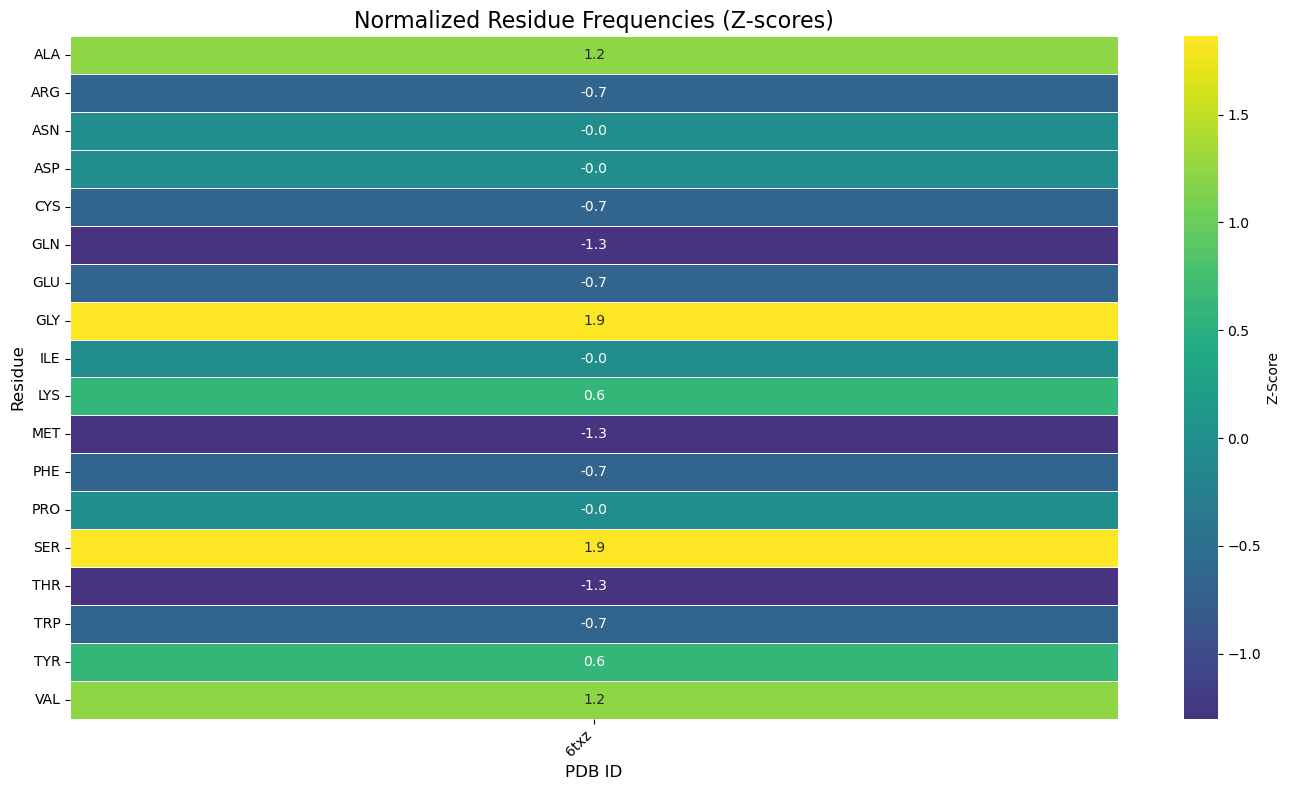

In [23]:
# Load pivoted frequency table
variable = 'tim3'
df = pd.read_csv(f"data/{variable}/{variable}_residue_frequencies_pivot.csv", index_col=0)



# Z-score across all values
df_z = df.apply(zscore, axis=0)

plt.figure(figsize=(14, 8))

sns.heatmap(
    df_z,
    cmap="viridis",
    center=0,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "Z-Score"}
)

plt.title("Normalized Residue Frequencies (Z-scores)", fontsize=16)
plt.ylabel("Residue", fontsize=12)
plt.xlabel("PDB ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"plots/{variable}_heatmap.pdf", bbox_inches = "tight")
plt.show()